In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from FourTankSystem import QuadTankSystem
from controllers import pi_controller

# ------------------------------------------------------------
#  Parameter values
# ------------------------------------------------------------

a1 = 1.2272     #[cm2] Area of outlet pipe 1
a2 = 1.2272    #[cm2] Area of outlet pipe 2
a3 = 1.2272     #[cm2] Area of outlet pipe 3
a4 = 1.2272     #[cm2] Area of outlet pipe 4
A1 = 380.1327   #[cm2] Cross sectional area of tank 1
A2 = 380.1327   #[cm2] Cross sectional area of tank 2
A3 = 380.1327   #[cm2] Cross sectional area of tank 3
A4 = 380.1327   #[cm2] Cross sectional area of tank 4
A = np.array([A1, A2, A3, A4])
g = 981         #[cm/s2] The acceleration of gravity
gamma1 = 0.45  # Flow distribution constant. Valve 1
gamma2 = 0.40  # Flow distribution constant. Valve 2
rho=1.00 # [g/cm3] Density of water 

# Collect parameters in a vector

p = {'a': np.array([a1, a2, a3, a4]), 'A': np.array([A1, A2, A3, A4]), 'g': g, 'gamma': np.array([gamma1, gamma2]), 'rho': rho}

# ------------------------------------------------------------
# Initial Conditions
# ------------------------------------------------------------

m10 = 0.0          # [g] Liquid mass in tank 1 at time t0
m20 = 0.0          # [g] Liquid mass in tank 2 at time t0
m30 = 0.0          # [g] Liquid mass in tank 3 at time t0
m40 = 0.0          # [g] Liquid mass in tank 4 at time t0
x0 = np.array([m10, m20, m30, m40]) # Initial conditions
# Now setting flow rates initially tso zero
F1 = 0           # [cm3/s] Flow rate from pump 1
F2 = 0           # [cm3/s] Flow rate from pump 2

# ------------------------------------------------------------
# Time
# ------------------------------------------------------------

N = 200 # Number of minutes to simulate
t0 = 0.0        # [s] Initial time
tf = N*60         # [s] Final time
t= np.linspace(t0,tf,N)

# ------------------------------------------------------------
# Initialising QuadTankSystem
# ------------------------------------------------------------

fourTankSys = QuadTankSystem(p)
fourTankSys.set_initial_condition(x0)

# ------------------------------------------------------------
# Initialising the State (mass), Sensor (all heights),
# Output (two heights) vectors and the input (flow rates) vector
# ------------------------------------------------------------
x = np.zeros((4,N))
x[:,0] = x0

y = np.zeros((4,N))
y[:,0] = fourTankSys.system_sensor(x0)

z = np.zeros((2,N))
z[:,0] = fourTankSys.system_output(x0) # Only the first two heights are measured

u = np.zeros((2,N))
u[:,0] = np.array([[F1,F2]])

In [10]:
X_d, T_d = np.zeros((4,1)), np.array([0])

# Target values
r = np.array([30,25])
Kp = 5e-1 # Proportional gain
Ki = 1e-1 # Integral gain
i = np.array([0,0])
dt = 1 # 1 minute
for k in range(0, N-1):
    
    y[:, k] = fourTankSys.system_sensor(x[:, k]) 
    z[:, k] = fourTankSys.system_output(x[:, k])
    if k==0:
        out = pi_controller(i, dt, r,z[:, k], u[:, k], Kp, Ki)
    else:
        out = pi_controller(i, dt,r,z[:, k], u[:, k-1], Kp, Ki)
    u[:, k] = out[0]
    i = out[1]
    sol = integrate.solve_ivp(fourTankSys.process, [t[k], t[k+1]], x[:, k], method='BDF', args=([u[:, k]]))
    x[:, k+1] = sol.y[:, -1]
    # if np.any(x[:, k+1] < 0):  # Ensure that the mass in the tanks is always positive
    #     x[:, k+1] = np.maximum(x[:, k+1], 0)
    X_d = np.append(X_d, x[:, k+1].reshape(4,1), axis=1)
    T_d = np.append(T_d, sol.t[-1])
    
    
k = N-1
y[:, k] = fourTankSys.system_sensor(x[:, k])
z[:, k] = fourTankSys.system_output(x[:, k])
u[:, k] = pi_controller(i, dt, r,z[:, k], u[:, k-1], Kp, Ki)[0]

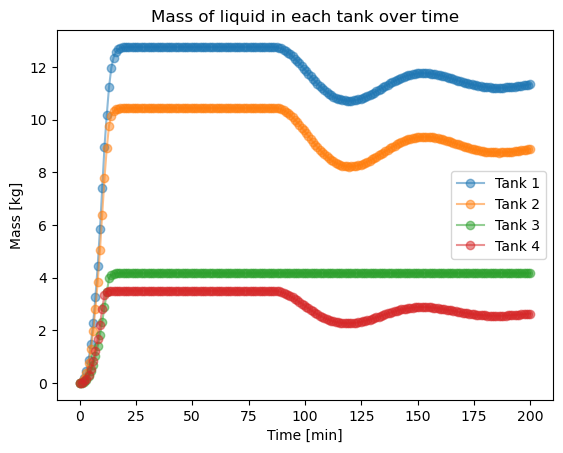

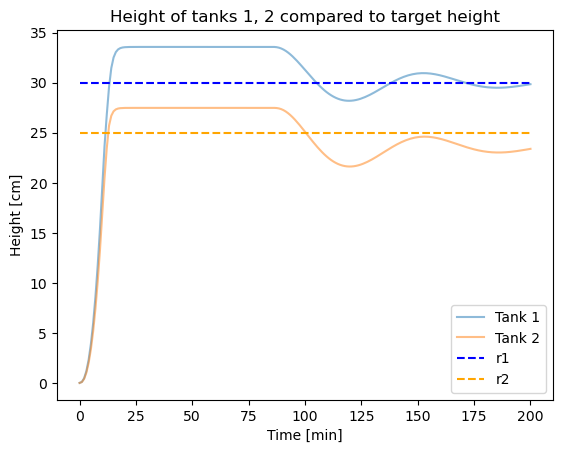

Final height of tank 1: 29.8551752280315
Final height of tank 2: 23.394248065014743
Target height of tank 1: 30
Target height of tank 2: 25


In [11]:
plt.plot(T_d/60, X_d.T/1000, linestyle='-', marker='o', alpha=0.5)
plt.xlabel('Time [min]')
plt.ylabel('Mass [kg]')
plt.title('Mass of liquid in each tank over time')
plt.legend(['Tank 1', 'Tank 2', 'Tank 3', 'Tank 4'])
plt.show()

plt.plot(T_d/60, z.T, linestyle='-', alpha=0.5)
plt.hlines(r[0], 0, N, colors='b', linestyles='dashed')
plt.hlines(r[1], 0, N, colors='orange', linestyles='dashed')
plt.xlabel('Time [min]')
plt.ylabel('Height [cm]')
plt.title('Height of tanks 1, 2 compared to target height')
plt.legend(['Tank 1', 'Tank 2', 'r1', 'r2'])
plt.show()

print('Final height of tank 1:', y[0, -1])
print('Final height of tank 2:', y[1, -1])
print(f"Target height of tank 1: {r[0]}")
print(f"Target height of tank 2: {r[1]}")

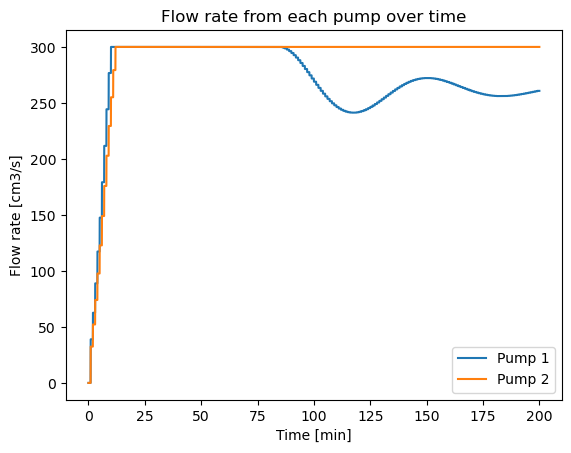

In [12]:

U = np.zeros((2, 20*N))
U[:, 0:20] = np.array([F1, F2]).reshape(2,1)*np.ones((2, 20))
t_U = np.linspace(0, tf, 20*N)
for i in range(1, N):
    U[:, 20*i:20*(i+1)] = u[:, i].reshape(2,1)*np.ones((2, 20))

plt.plot(t_U/60, U[0,:], label='Pump 1')
plt.plot(t_U/60, U[1,:], label='Pump 2')
plt.xlabel('Time [min]')
plt.ylabel('Flow rate [cm3/s]')
plt.title('Flow rate from each pump over time')
plt.legend()
plt.show()